# Projet: Modélisation du trafic routier 

###### *Mathias Bichon* 
###### *Victor Robert*

###### Groupe: LDD3 Maths Info


## Table des matières:
* [Partie 1: Approche microscopique](#partie1)
    - [Modélisation mathématique](#partie1maths)
    - [Modélisation numérique](#partie1info)
        - [Exemple 1: générique](#partie1infoex1)
        - [Exemple 2: vitesse gaussienne pour la première voiture](#partie1infoex2)
        - [Exemple 3: feu rouge](#partie1infoex3)
        - [Exemple 4: Plusieurs feux rouges](#partie1infoex4)
        - [Les bouchons](#partie1infobouchons)
        - [Les limites du modèle](#partie1infolimite)
    - [Ajustement du pas de temps](#partie1pastemps)
    - [Ajout d'un temps de réaction](#partie1tempsreac)
* [Conclusion](#partie2)

In [250]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

##### références: 
- http://fsavy.vvv.enseirb-matmeca.fr/reports/memoire_cpbx_savy_troles_trafic.pdf
- https://en.wikipedia.org/wiki/Intelligent_driver_model
- https://www-sop.inria.fr/members/Guillaume.Costeseque/premi_abertis_costeseque.pdf

<a id='partie1'></a>

## Partie 1: Approche microscopique

<a id='partie1maths'></a>
### Modélisation mathématique:


Nous allons modéliser le trafic routier à l'échelle $\textbf{microscopique}$. C'est-à-dire que l'on va s'intéresser au comportement des voitures considérées individuellement, et pas au flux de trafic.

Afin de simplifier le problème, nous décriverons des voitures sur une seule route, sans accident ni de ronds points.

Nous nous appuierons sur le modèle "Intelligent_driver_model" qui fût développé dans les années 2000 par Treiber, Hennecke et Helbing. Nous pouvons dors et déjà nous interroger sur le mot "intélligent" dans le nom du modèle. Est ce que c'est un coup de marketing, est ce qu'un modèle qui suit des lois déterministes peut être intélligent dans le sens humain du terme ? Le cerveau humain n'est il pas une fonction qui prend en argument les données sensorielles et qui renvoit des signaux électriques aux muscles et autres organes du corps ? Dans ce cas, est ce que la différence entre humain et machine est qu'une question de nombre de paramètres ? Nous approfondirons pas plus dans ce rapport sur cette question qui est de nature quasi philosophique.

Les variables qui décrivent le comportement de la voiture $n$ sont :
- Sa vitesse $v_n(t)$
- Sa position $x_n(t)$
- Sa accélération $a_n(t)$
- Sa distance à la voiture d'en face $s_n$

Le modèle considéré suppose que le comportement de la $n$-ième voiture dépend uniquement du comportement de la voiture en face (qui sera la voiture numéro $n$-1).
Ainsi notre modèle en temps continu fera intevenir les équations différentielles suivantes :

- $x'_n(t) = v_n(t)$
- $ds(v, dv) = s_0 + max( 0, T*v + \frac{v * dv}{2 * \sqrt{ab}})$ où dv est la différence entre la vitesse du véhicule d'en face et celle du véhicule étudié.
- $a_n(t)=v'_n(t) = a(1 - (v_n(t) / v_0)^4 - (ds(v_n, dv_n)/s_n)^2)$ 
- $x_n(0) = n(1+100*s0)$

Avec les paramètres suivants:
- $n$ : le nombre de voitures
- $v0$ : la vitesse maximale (qui peut être lié aux contraintes physiques sur la voiture mais aussi aux lois routières)
- $s0$ : la distance minimale avec la voiture d'en face (on ne peut pas la coller)
- $T$ : temps minimal pour rattraper une voiture en secondes
- $a$ : accélération maximale
- $b$ : temps de ralentissement confortable
- $l$ : longueur des véhicules (supposée la même pour chacun)

Le modèle a beaucoup de paramètres,pour le simplifier nous supposeront que tous les véhicules aient des paramètres identiques.

Le comportement des véhicules ne dépendra que de leur position initiale et de leur accélération. Nous décrivons donc son équation ci dessous:

On aimerait que l'accélération des voitures dépende d'un facteur "intrinsèque" lié aux contraintes de la voiture indépendemment des autres voitures, et d'un facteur "extrinsèque" qui représente le comportement de la voiture par rapport aux autres véhicules, et plus particulièrement du véhicule devant.
Nous pouvons donc séparer l'accélération en deux termes, dont chacun décrit un cas:
- $(v_n(t) / v_0)^4$ décrit le facteur "intrinsèque" du comportement de la voiture. On peut remarquer un cas limite, que quand $s_n$ est "grand", c'est à dire que le véhicule devant est très éloigné, le deuxième terme qui régit ($(ds(v_n, dv_n)/s_n)^2$) va être presque nul, et le seul facteur qui va influencer le comportement de la voiture sera le facteur intrinsèque. Ce facteur est simplement le rapport entre la vitesse actuelle et la vitesse maximale. Dans ce cas l'accélération sera égale à: $a(1-(\frac{v_n}{v_0})^4)$ où $v_0$ est la vitesse maximale et $a$ est l'accélération maximale. Ce terme satisfait les propriétés qu'on souhaite, qui sont qu'il tend vers 0 lorsque la vitesse actuelle s'approche de la vitesse maximale et qu'il se rapproche de l'accélération maximale lorsque la vitesse actuelle est très en dessous de la vitesse maximale. De plus nous souhaitons que la voiture atteigne rapidement sa vitesse maximale, comme un humain sur l'autoroute qui va tenter d'arriver à la limite de vitesse le plus vite possible. Puisque $(\frac{v_n}{v_0})<1$ la puissance 4 nous garanti que ce terme sera très faible (et donc l'accélération élevée) lorsque la voiture n'a pas atteint sa vitesse maximale. La vitesse de la voiture convergera rapidement vers sa vitesse maximale en l'absence d'autres voitures.  
- $(ds(v_n, dv_n)/s_n)^2$ Quand les voitures sont proches, on voudrait plutôt que l'accélération soit faible lorsque la distance à la voiture d'en face se rapproche de la distance minimale pare-choc à pare-choc. Un terme adapté dans ce cas est alors :
- $a(1 - \frac{\text{distance minimale pare-choc à pare-choc}}{\text{distance à la voiture d'en face}})$
qui s'écrit encore $a(1 - \frac{ds(v_n, dv_n)}{s_n})$ Pour la distance minimale pare-choc à pare-choc qu'il faut respecter $ds$, elle est toujours supérieure ou égale à $s_0$. À ce $s_0$, on devrait ajouter la distance nécessaire pour réaliser une manoeuvre d'urgence à la vitesse actuelle.Le temps exigé pour réaliser cette manoeuvre, $T$ (souvent égal à une seconde), est alors multiplié par la vitesse actuelle ce qui donne la distance parcourue le temps de réaliser la manoeuvre. Finalement, on se sert également d'un terme qui contrôle comment un véhicule s'approche d'un véhicule plus lent que lui, qui correspond au terme: $\frac{v * dv}{2 * \sqrt{ab}}$. Ce terme respecte bien les propriétés qu'on voudrait: En effet plus on se rapproche rapidement ($v$) d'un véhicule lent ($dv$) plus on souhaite ralentir. Pour bien comprendre le terme $\frac{v * dv}{2 * \sqrt{ab}}$, regardons le comme cela. Dans le cas critique où on approche une voiture au repos ou très lente, on peut considérer que $dv = v$, on alors que :
- On anticipe toujours une décélération de $b_k = \frac{v^2}{2s}$ pour éviter une collision. On considère cela comme acceptable si ce terme est inférieur à b, i.e. si $b_k/b \leq 1$ et on considère qu'on est en danger si ce coefficient est supérieur à 1. Finalement, ce tel coefficient qui informe sur la situation actuelle peut-être \multiplié par la décélération anticipée pour l'augmenter ou la réduire au besoin, elle est alors égale à : $\frac{v^2}{2s} \times \frac{1}{b} \times \frac{v^2}{2s} = v^4 / 4*s*b = (\frac{(v^2)^2}{4*s*b} = (\frac{v*dv}{2*s*\sqrt{b}})^2$, finalement en factorisant par $a$ on retrouve le terme qui contrôlait le freinage $(\frac{v * dv}{2 * \sqrt{ab}})^2$.
On trouve que dans les cas critiques, on a bien l'accélération qui se rapproche de $-b$



Finalement on peut remarquer que l'accélération peut être négative: Lorsque la vitesse maximale est atteinte, le véhicule va soit arrêter d'accélerer soit décélérer. Le véhicule peut aussi décélérer à une vitesse plus lente, si il est proche d'un véhicule très lent devant.

##### comportement de la première voiture:
Le modèle décrit le comportement d'une voiture en fonction de la voiture en face, cependant la première voiture n'a pas de véhicule devant et donc nous devons "fixer" son comportement nous même. Nous le faisons de deux manières:
- On considère que la première voiture est comme les autres voitures avec une distance "infinie" avec la voiture de devant. Nous le modélisons en fixant $ds$ à 0. Nous pouvons aussi simuler de cette façon un feu de circulation, qui est un véhicule de vitesse nulle.
- Nous faisons suivre à la vitesse de la première voiture une fonction prédéfinie en fonction du temps. De cette manière nous pouvons induire des phénomènes étranges qui ne seraient pas possibles dans la "vraie", ce qui nous permet de tester les lmites du modèle. Ce cas là sera exploré dans l'exemple 3.

<a id='partie1info'></a>
### Modélisation numérique: 

Résolvons ce système avec la méthode d'Euler, car on ne peut le faire analytiquement.

In [251]:
def dfs(vn,dVn,s0,a,b,T):
    return s0+max(0,T*vn+(vn*dVn)/(2*np.sqrt(a*b)))
    
    
def acceleration(a,vn,v0,ds,Sn):
    return a*(1-(vn/v0)**4-(ds/Sn)**2)


"""
n : le nombre de voitures
v0 : la vitesse maximale
s0 : la distance minimale avec la voiture d'en face (on ne peut pas la coller)
T : temps minimal pour rattraper une voiture en secondes
a : accélération maximale
b : temps de ralentissement confortable
l : longueur des véhicules (suposée la même pour chacun)
"""
'''
Une liste de paramètres classiques.
'''
liste_param = [
    {
        'n' : 10,
        'v0': 100,
        's0': 2,
        'T' : 1,
        'a' : 0.5,
        'b' : 0.2,
        'l' : 5
    }
]

In [252]:
"""
Renvoie les vecteurs position, vitesse et acceleration pour chaque voiture (n voitures),
et pour un certain nombre de répetitions (K), le temps total écoulé sera de t=K*dt
"""
def trafic_euler(n, v0, s0, T, a, b, l,K):
    X = np.zeros((K,n))
    X[0] = np.linspace(n*(l+100*s0),0, n)
    V = np.zeros((K,n))
    A = np.zeros((K,n))
    t = np.zeros(K)
    dt = 0.01
    
    for k in range(1,K):
        t[k] = t[k-1]+dt
        for v in range(n):
            if v ==0:
                ds = 0
                sn = 1
            else:
                dv = abs(V[k-1][v-1]-V[k-1][v])
                sn = X[k-1][v-1]-X[k-1][v] - l 
                ds = dfs(V[k-1][v],dv,s0,a,b,T)
            A[k][v] = acceleration(a,V[k-1][v],v0,ds,sn)
            V[k][v] = V[k-1][v]+A[k-1][v]*dt
            X[k][v] = X[k-1][v]+V[k-1][v]*dt
    return t,X,V,A

Maintenant affichons le résultat obtenu.
On peut modifier la valeur de M pour afficher différentes courbes (position, vitesse et accélération)

<a id='partie1infoex1'></a>
#### Exemple 1: générique

On va simplement éxecuter le modèle et afficher le résultat obtenu pour avoir une idée de avec quoi on travaille.

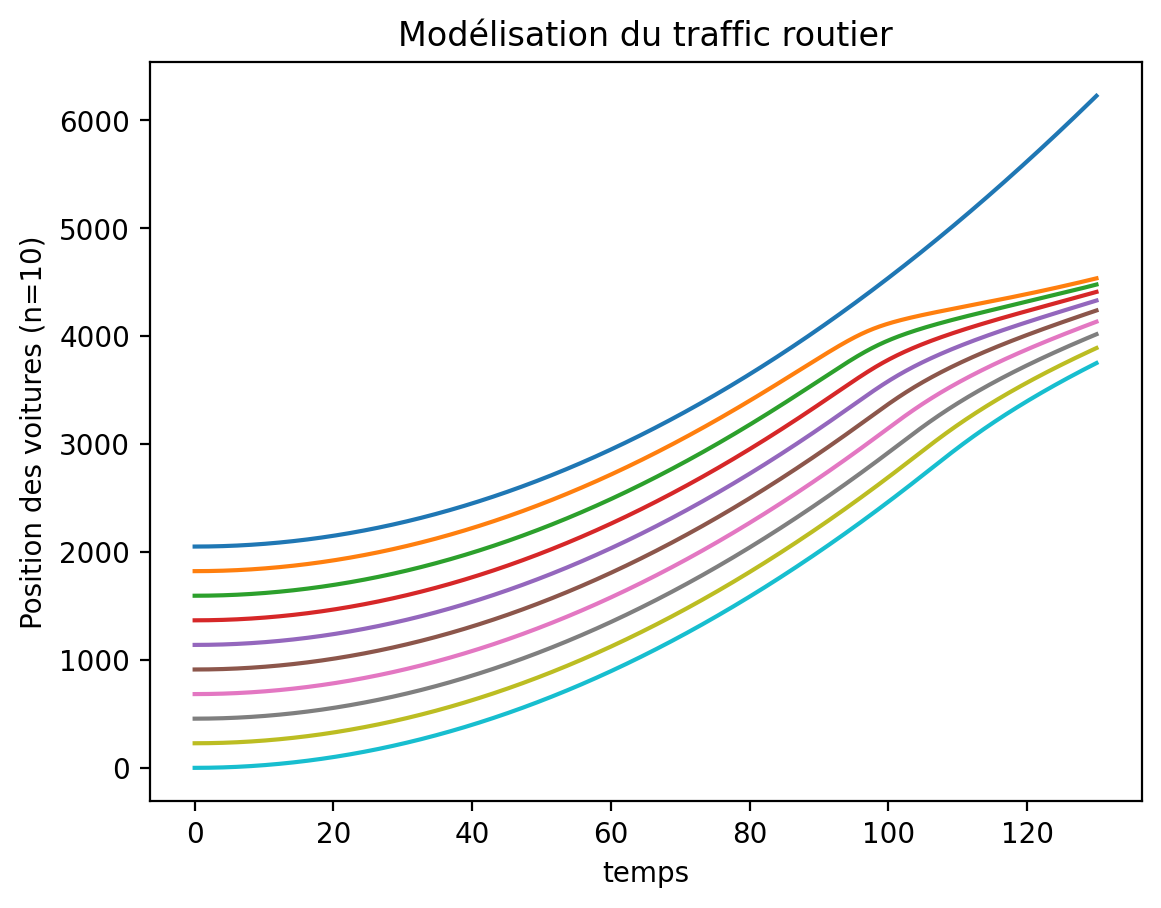

In [253]:
n,v0,s0,T,a,b,l = liste_param[0].values() #On extrait les paramètres
K = 13000 #Le nombre de fois où la boucle du schéma Euler va être affectuée, correspond au temps au pas de temps près. (T=K*dt)
t,X,V,A = trafic_euler(n, v0, s0, T, a, b, l,K)

# A modifier: M représente la courbe qui sera affichée
M = X # prend les valeurs: X,V,A
ylabel = "Position" if M.all()==X.all() else ("Vitesse" if M.all()==V.all() else "Acceleration")  

for v in range(n):
    x = M[:,v]
    plt.plot(t,x)
    
plt.xlabel("temps")
plt.ylabel(f"{ylabel} des voitures (n={n})")
plt.title("Modélisation du traffic routier");

###### commentaire: dans ce simple exemple on peut dors et déjà voir apparaitre des anomalies dans le comportement des voitures. Pourquoi la deuxième voiture frêne t-elle si brusquement ? Est ce qu'il s'agit d'une question s'optimisation de paramètres ou y t-il quelque chose qui cloche dans notre modèle ? Puisque la deuxième voiture frêne trop brutalement, les paramètres à changer sont sûrement $a$ ou $b$ car ce sont eux qui régissent l'accélération.

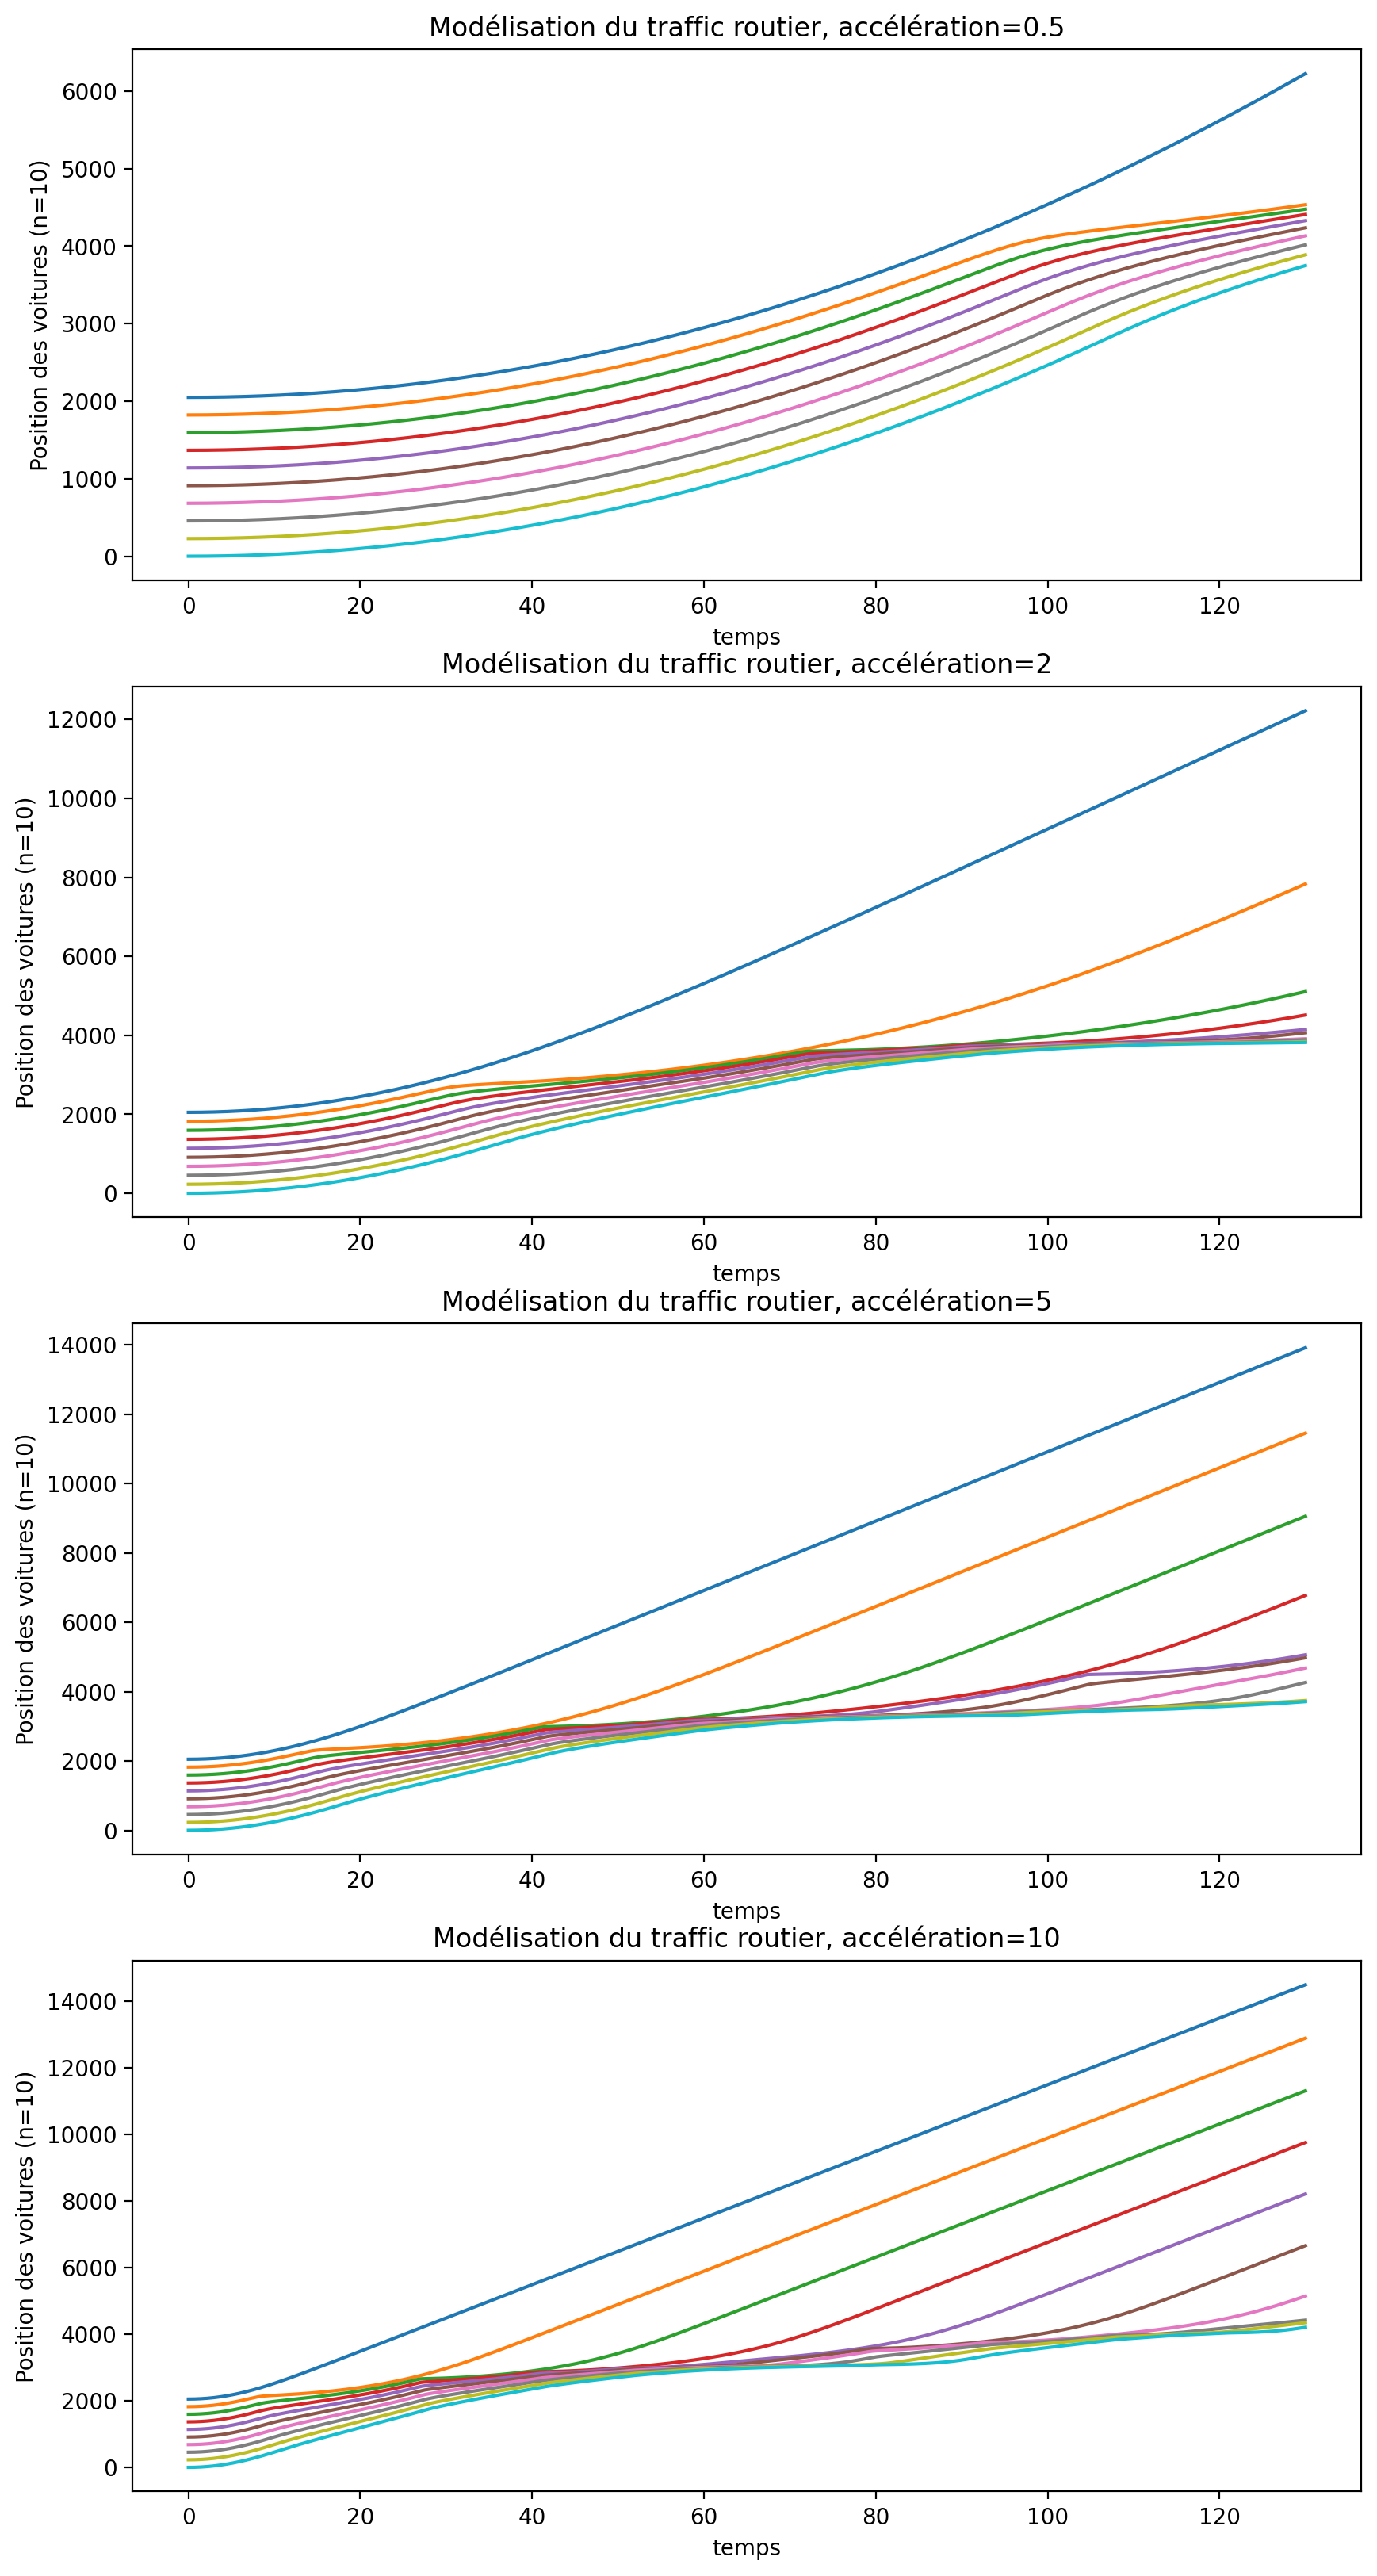

In [254]:
n,v0,s0,T,a,b,l = liste_param[0].values() #On extrait les paramètres
K = 13000 #Le nombre de fois où la boucle du schéma Euler va être affectuée, correspond au temps au pas de temps près.(T=K*dt)
A_modif = [0.5,2,5,10]
fig, ax = plt.subplots(len(A_modif),figsize=(10,20))


for i,a_modif in enumerate(A_modif):
    # A modifier: M représente la courbe qui sera affichée
    t,X,V,A = trafic_euler(n, v0, s0, T, a_modif, b, l,K)
    M = X # prend les valeurs: X,V,A
    ylabel = "Position" if M.all()==X.all() else ("Vitesse" if M.all()==V.all() else "Acceleration")  

    for v in range(n):
        x = M[:,v]
        ax[i].plot(t,x)
    ax[i].set_xlabel("temps")
    ax[i].set_ylabel(f"{ylabel} des voitures (n={n})")
    ax[i].set_title(f"Modélisation du traffic routier, accélération={a_modif}");


###### commentaire: Nous remarquons que la valeur de $a$ ne change pas la présence du phénomène de tassage des voitures. Cependant avec des valeurs de $a$ plus élevées les voitures se tassent pendant moins longtemps (car elles accélèrent rapidement), et asymptotiquement ont un intervalle plus court entre elles.  Puisque les voitures sont loins entre elles ($sn$ grand donc $(ds/sn)^2$ proche de 0) et qu'elles atteignent très rapidement leur vitesse maximale ($(v_n/v0)^4$ proche de 0), la vitesse devient: $v_n(t)= a(1-0-0)=a$, une constante, ce qui explique l'allure asymptotique en ligne droite de la position. Cependant on a toujours l'effet de tassement.

Maintenant modifions la valeur de $b$ ! 

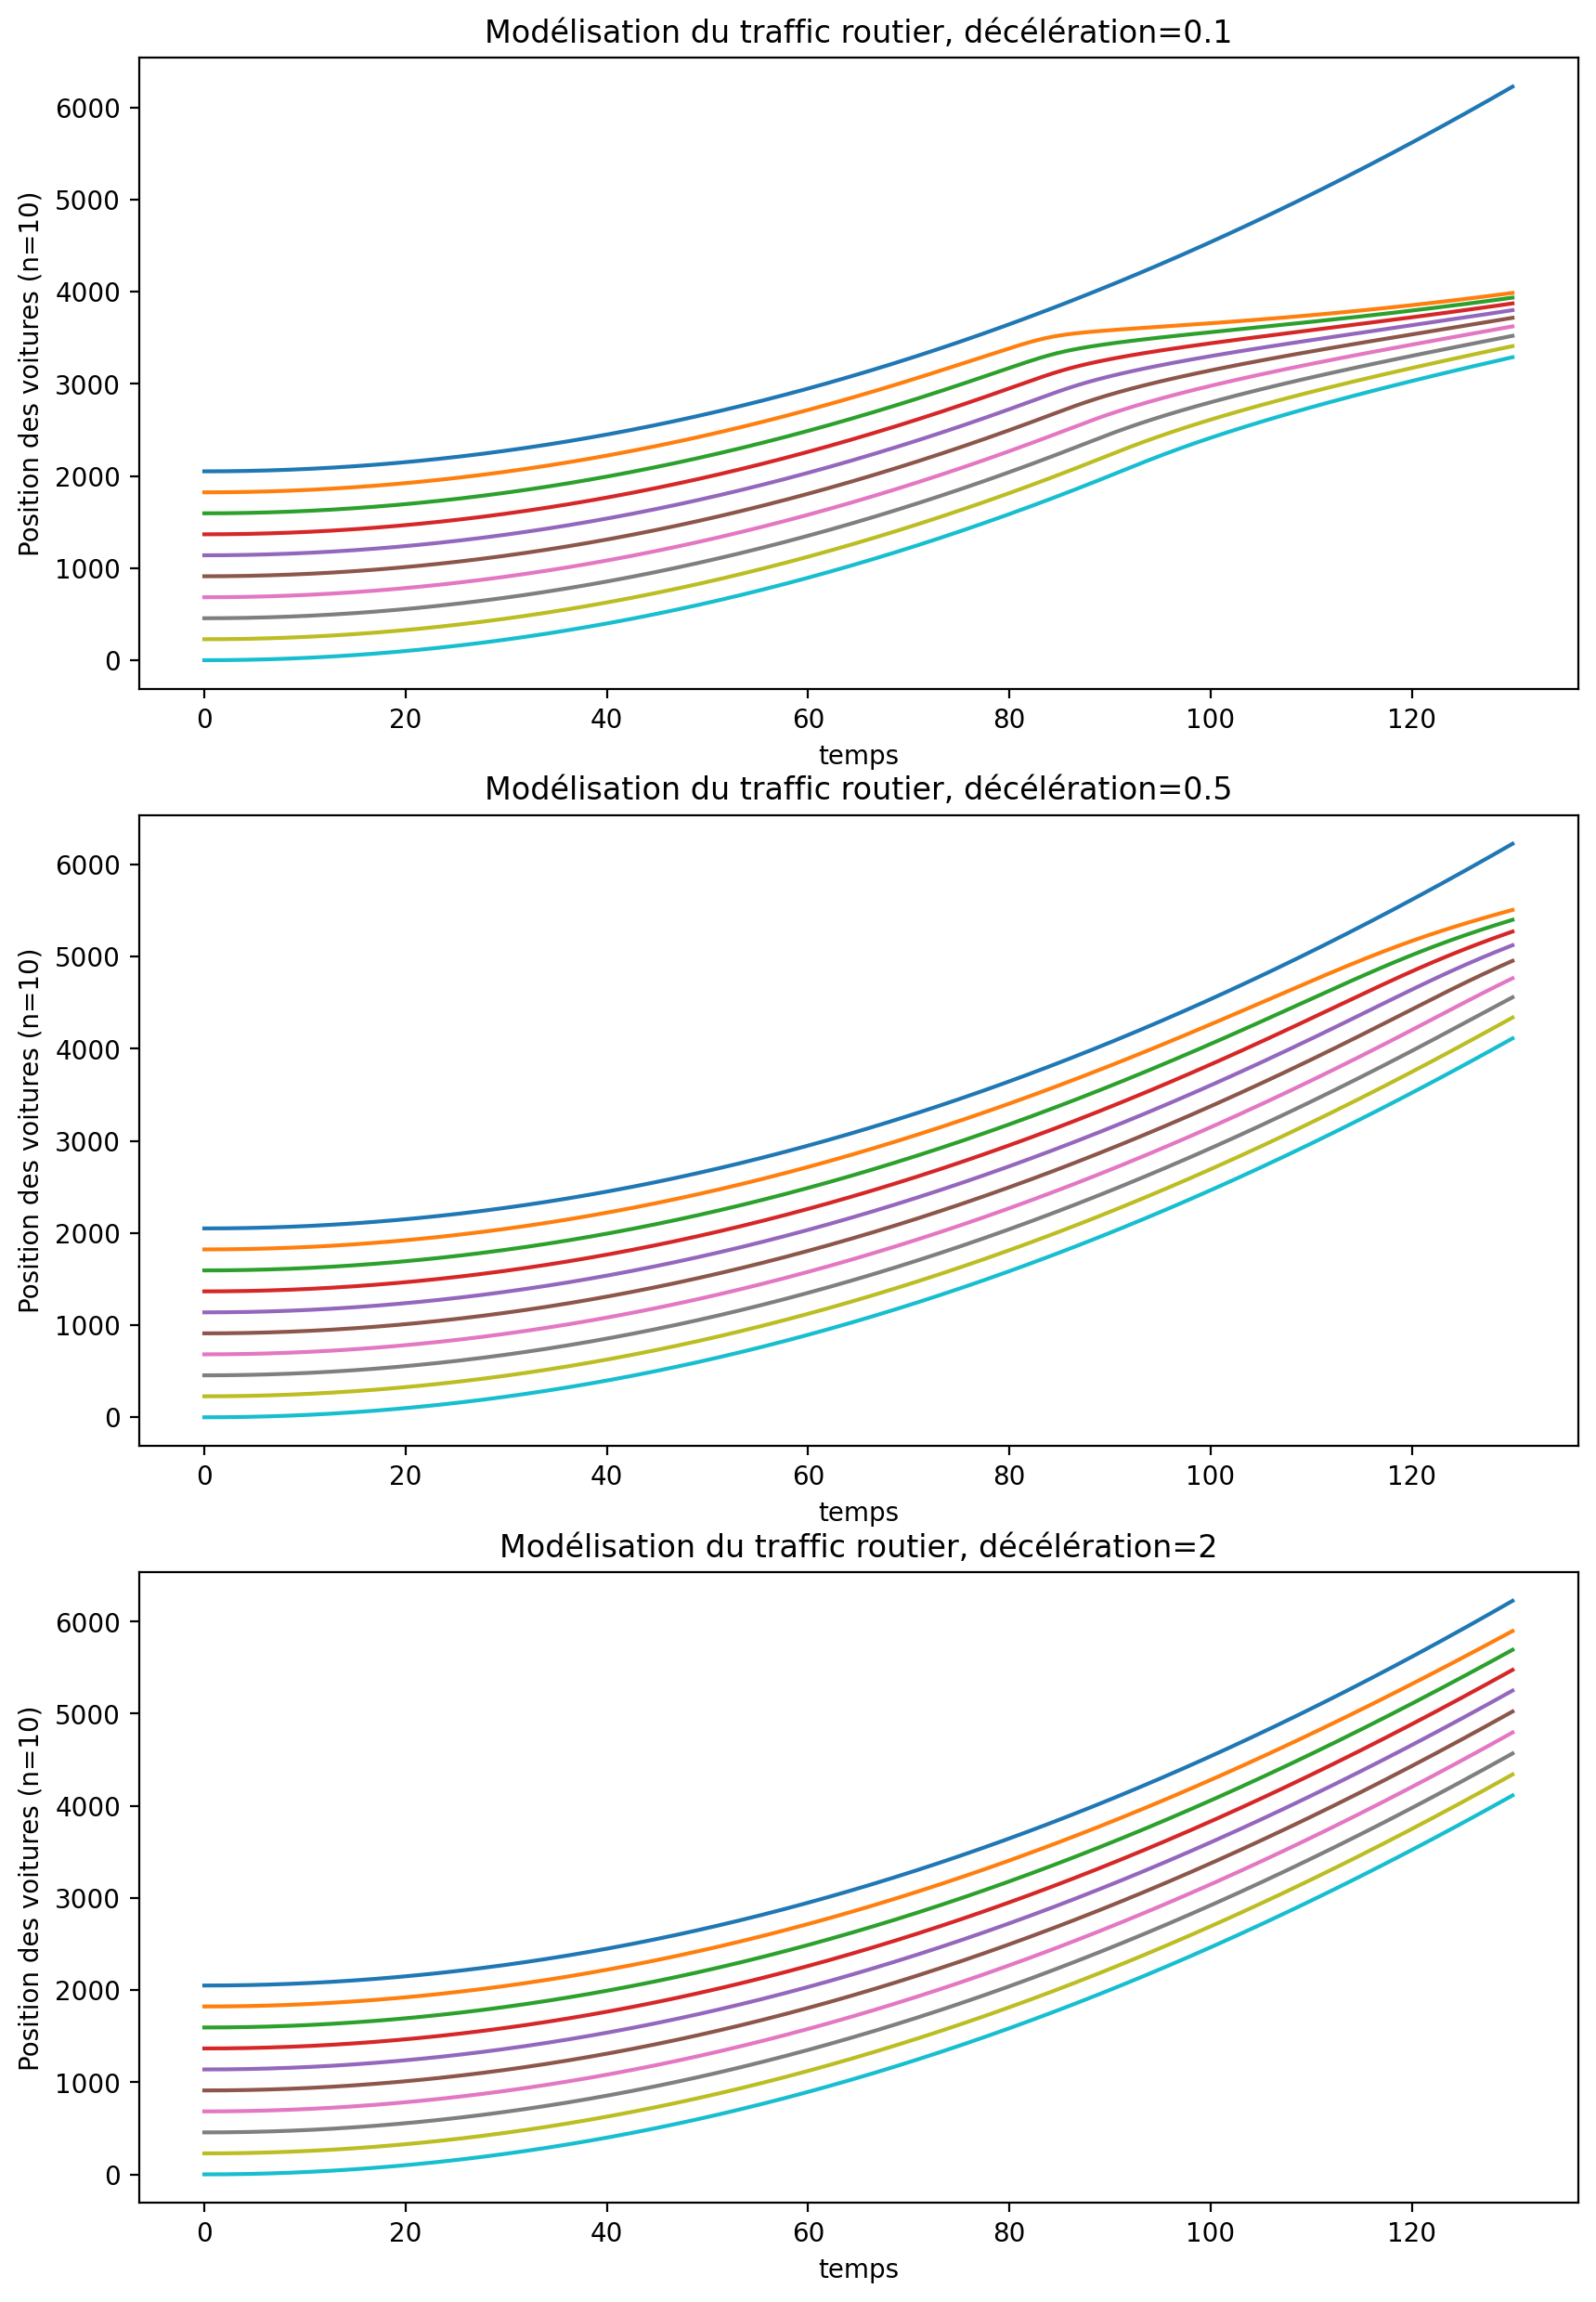

In [255]:
n,v0,s0,T,a,b,l = liste_param[0].values() #On extrait les paramètres
K = 13000 #Le nombre de fois où la boucle du schéma Euler va être affectuée, correspond au temps au pas de temps près.(T=K*dt)
B_modif = [0.1,0.5,2]
fig, ax = plt.subplots(len(B_modif),figsize=(10,15))


for i,b_modif in enumerate(B_modif):
    # A modifier: M représente la courbe qui sera affichée
    t,X,V,A = trafic_euler(n, v0, s0, T, a, b_modif, l,K)
    M = X # prend les valeurs: X,V,A
    ylabel = "Position" if M.all()==X.all() else ("Vitesse" if M.all()==V.all() else "Acceleration")  

    for v in range(n):
        x = M[:,v]
        ax[i].plot(t,x)
    ax[i].set_xlabel("temps")
    ax[i].set_ylabel(f"{ylabel} des voitures (n={n})")
    ax[i].set_title(f"Modélisation du traffic routier, décélération={b_modif}");


###### commentaire: On remarque que plus $b$ est élevé moins il y a de tassement de voitures ! En réalité on pouvait s'y attendre car $b$ est le paramètre qui contrôle la décélération des voitures, et que le problème qu'on avait était que les voitures décéléraient trop brusquement.

<a id='partie1infoex2'></a>

#### Exemple 2: vitesse gaussienne pour la première voiture
Voici un exemple de modélisation, avec la vitesse de la première voiture qui va suivre une fonction gaussienne.
Nous commençons par re-définir la fonction euler avec une vitesse prédéfinie pour la première voiture. 

In [256]:
'''
Fonction qui permet de fixer une certaine vitesse à la première voiture en fonction du temps.
'''
def vitesse_premiere_voiture(t):
    '''
    On commence par donner une vitesse gaussienne à la voiture
    '''
    return 1000/np.sqrt(2*np.pi*1000)*np.exp(-(100-t)**2/(2*1000))

'''
Même fonction euler, mais avec la vitesse de la première voiture qui suit une fonction prédéfinie
'''
def trafic_euler_vitesse_predef(n, v0, s0, T, a, b, l,K):
    X = np.zeros((K,n))
    X[0] = np.linspace(n*(l+100*s0),0, n)
    V = np.zeros((K,n))
    A = np.zeros((K,n))
    t = np.zeros(K)
    dt = 0.01
    
    for k in range(1,K):
        t[k] = t[k-1]+dt
        for v in range(n):
            if v ==0:
                V[k][v] = vitesse_premiere_voiture(t[k])
                A[k][v] = V[k][v]-V[k-1][v]
            else:
                dv = abs(V[k-1][v-1]-V[k-1][v])
                sn = X[k-1][v-1]-X[k-1][v] - l 
                ds = dfs(V[k-1][v],dv,s0,a,b,T)
                A[k][v] = acceleration(a,V[k-1][v],v0,ds,sn)
                V[k][v] = V[k-1][v]+A[k-1][v]*dt
            X[k][v] = X[k-1][v]+V[k-1][v]*dt
    return t,X,V,A

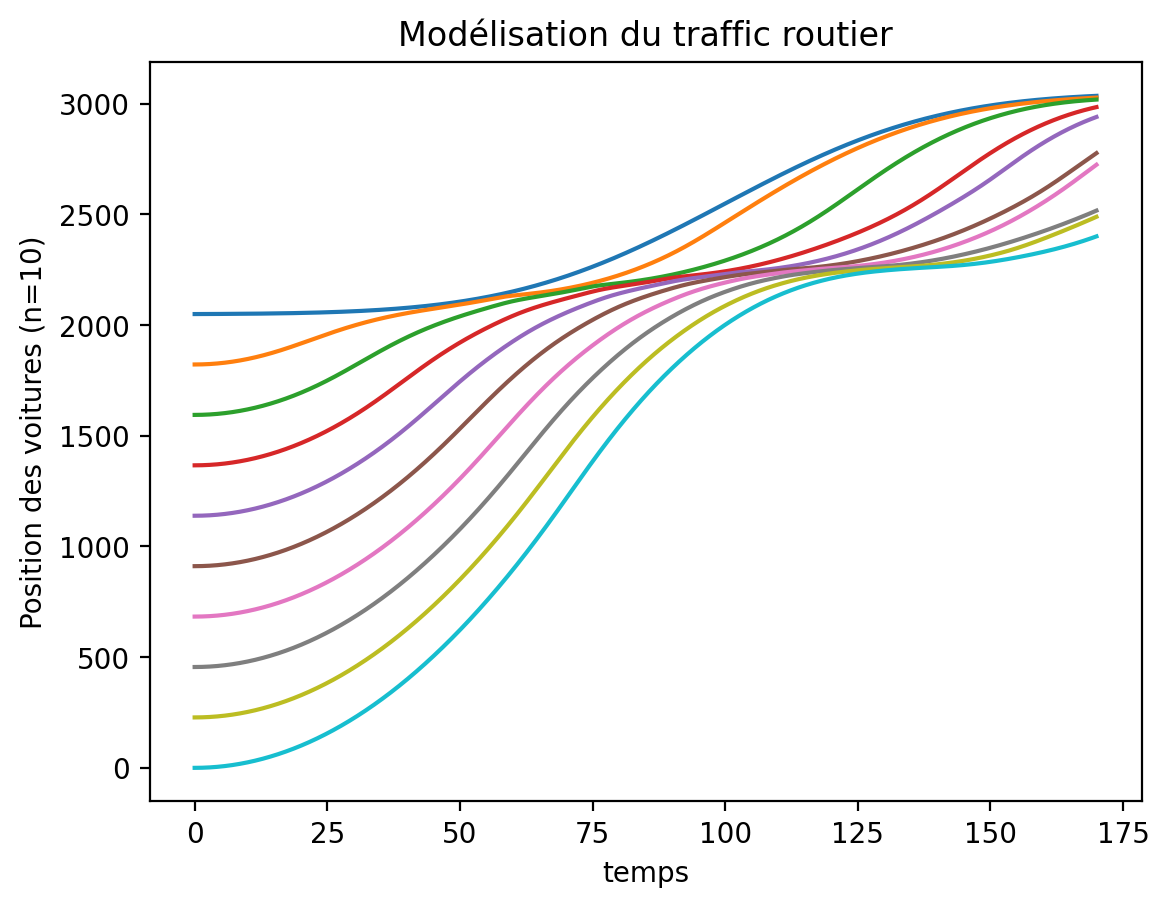

In [257]:
n,v0,s0,T,a,b,l = liste_param[0].values() #On extrait les paramètres
K = 17000 #Le nombre de fois où la boucle du schéma Euler va être affectuée, correspond au temps au pas de temps près. (T=K*dt)
t,X,V,A = trafic_euler_vitesse_predef(n, v0, s0, T, a, b, l,K)

# A modifier: M représente la courbe qui sera affichée
M = X # prend les valeurs: X,V,A
ylabel = "Position" if M.all()==X.all() else ("Vitesse" if M.all()==V.all() else "Acceleration")  

for v in range(n):
    x = M[:,v]
    plt.plot(t,x)
    
plt.xlabel("temps")
plt.ylabel(f"{ylabel} des voitures (n={n})")
plt.title("Modélisation du traffic routier");

<a id='partie1infoex3'></a>

#### Exemple 3: feu rouge

Nous allons ajouter un feu rouge à une distance de $4000m$ de la première voiture. Il nous faut encore définir une fonction euler qui nous le permet.

In [258]:
"""
Renvoie les vecteurs position, vitesse et acceleration pour chaque voiture (n voitures),
et pour un certain nombre de répetitions (K), le temps total écoulé sera de t=K*dt
De plus cette fonction prend en argument le distance du feu rouge et 
"""
def trafic_euler_feu_rouge(n, v0, s0, T, a, b, l,K):
    X = np.zeros((K,n))
    X[0] = np.linspace(n*(l+100*s0),0, n)
    V = np.zeros((K,n))
    A = np.zeros((K,n))
    t = np.zeros(K)
    dt = 0.01
    
    for k in range(1,K):
        t[k] = t[k-1]+dt
        for v in range(n):
            if v ==0:
                dv = abs(V[k-1][v])
                ds = dfs(V[k-1][v],dv,s0,a,b,T)
                sn = 4000-X[k-1][v] #distance au feu rouge
            else:
                dv = abs(V[k-1][v-1]-V[k-1][v])
                sn = X[k-1][v-1]-X[k-1][v] - l 
                ds = dfs(V[k-1][v],dv,s0,a,b,T)
            A[k][v] = acceleration(a,V[k-1][v],v0,ds,sn)
            V[k][v] = V[k-1][v]+A[k-1][v]*dt
            X[k][v] = X[k-1][v]+V[k-1][v]*dt
    return t,X,V,A

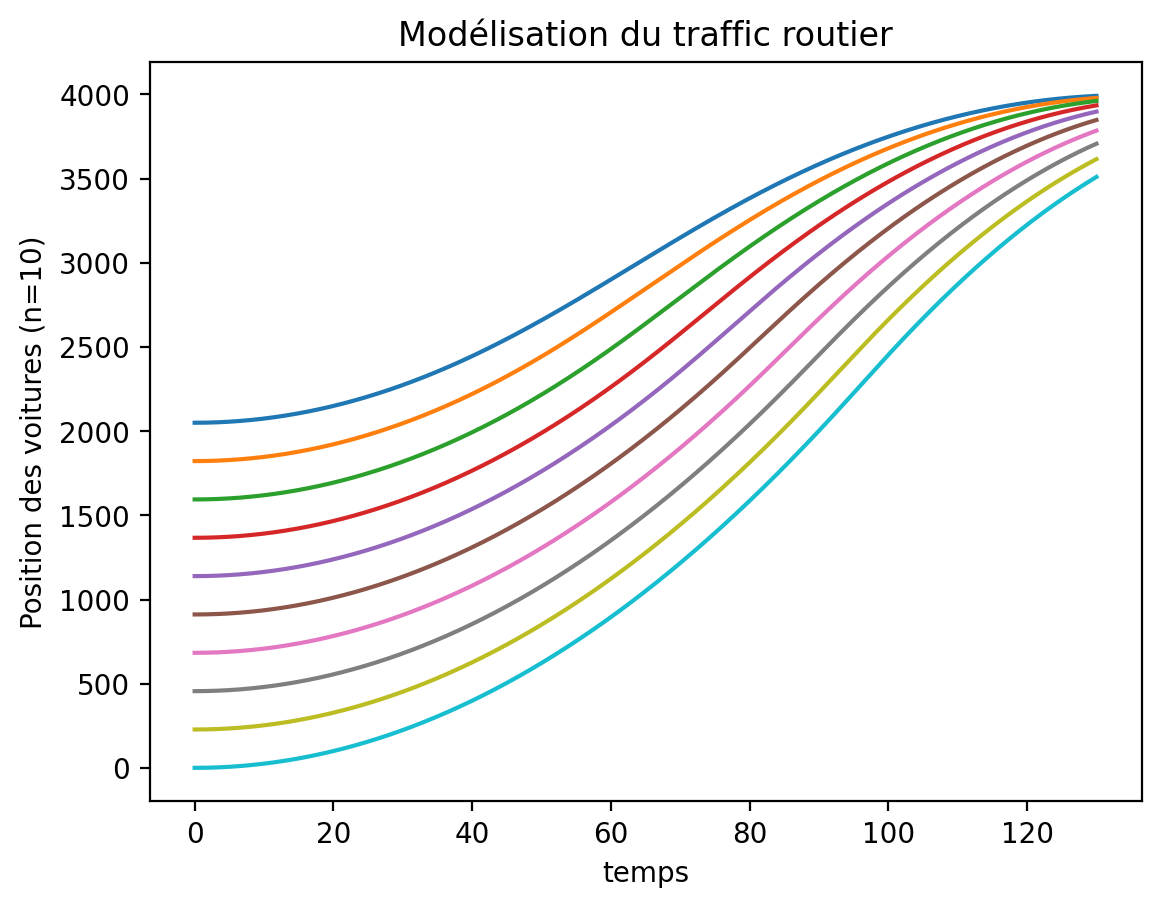

In [259]:
n,v0,s0,T,a,b,l = liste_param[0].values() #On extrait les paramètres
K = 13000 #Le nombre de fois où la boucle du schéma Euler va être affectuée, correspond au temps au pas de temps près. (T=K*dt)
t,X,V,A = trafic_euler_feu_rouge(n, v0, s0, T, a, b, l,K)

# A modifier: M représente la courbe qui sera affichée
M = X # prend les valeurs: X,V,A
ylabel = "Position" if M.all()==X.all() else ("Vitesse" if M.all()==V.all() else "Acceleration")  

for v in range(n):
    x = M[:,v]
    plt.plot(t,x)
    
plt.xlabel("temps")
plt.ylabel(f"{ylabel} des voitures (n={n})")
plt.title("Modélisation du traffic routier");

<a id='partie1infobouchons'></a>
#### Les bouchons

Pour un grand nombre de voitures sur une grande distance on voit des problèmes apparaître ! Surtout lorsque les voitures frênent fortement! 

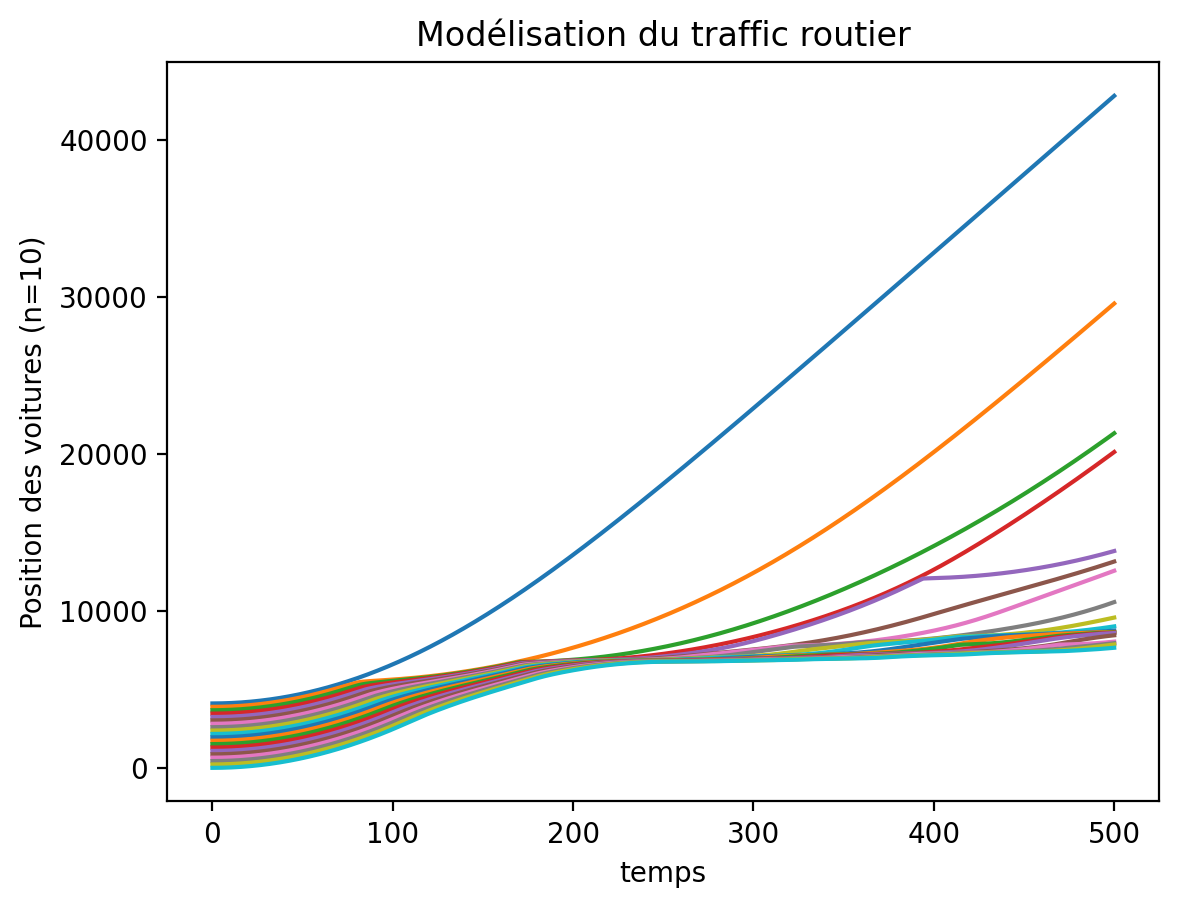

In [260]:
K = 50000 #Le nombre de fois où la boucle du schéma Euler va être affectuée, correspond au temps au pas de temps près. (T=K*dt)
bouchon_n = 20
t,X,V,A = trafic_euler(bouchon_n, v0, s0, T, a, 0.1, l,K)

# A modifier: M représente la courbe qui sera affichée
M = X # prend les valeurs: X,V,A
ylabel = "Position" if M.all()==X.all() else ("Vitesse" if M.all()==V.all() else "Acceleration")  

for v in range(bouchon_n):
    x = M[:,v]
    plt.plot(t,x)
    
plt.xlabel("temps")
plt.ylabel(f"{ylabel} des voitures (n={n})")
plt.title("Modélisation du traffic routier");

###### commentaire: Le phénomène qu'on avait vu dans le premier exemple se réplique de voiture en voiture, le résultat: un bouchon ! On peut remarquer qu'il y a un équilibre entre bouchons et sécurité: En effet nous pourrions éliminer ces bouchons en diminuant la décélération des voitures, mais cela n'est que possible dans un modèle mathématique dans lequel tout se passe comme on le souhaite, dans la vie réelle ce n'est pas réaliste de frêner au dernier moment quand on s'approche d'une voiture.

<a id='partie1infolimite'></a>
#### Comment casser le modèle ? 

Nous détaillons dans cette partie quelques manières que nous avons trouvé pour induire une anomalie dans le modèle.
Parfois il est difficile de savoir qu'est ce qui a cassé le modèle au juste, et donc nos interprétations sont au stage d'hypothèses.

À notre surprise il a été très facile de créer des bugs, il suffisait typiquement de modifier les paramètres d'un ordre de grandeur. Nous avons été étonné par la fragilité du modèle, qui nous semblait robuste mathématiquement, mais qui en réalisté ne fonctionne que sur un intervalle de paramètres étroit et bien définis. Nous avons réflechis sur les causes probables de cette instabilité:
- Utilisation du schéma d'euler: Le schéma d'euler fait partie d'une classe de méthodes qui s'intitulent méthode de runge-kutta, dont la méthode d'euler est celle qui a le taux d'erreur le plus élevé (l'erreur est proportionnelle au pas de temps), d'autres méthodes d'ordre plus élevées ont une vitesse de convergence plus rapide.
- Le modèle que nous avons choisi a un nombre un trop élevé de paramètres, et donc contrôler sa convergence est difficile. Il a un comportement chaotique.

###### Feu rouge qui fait reculer une voiture

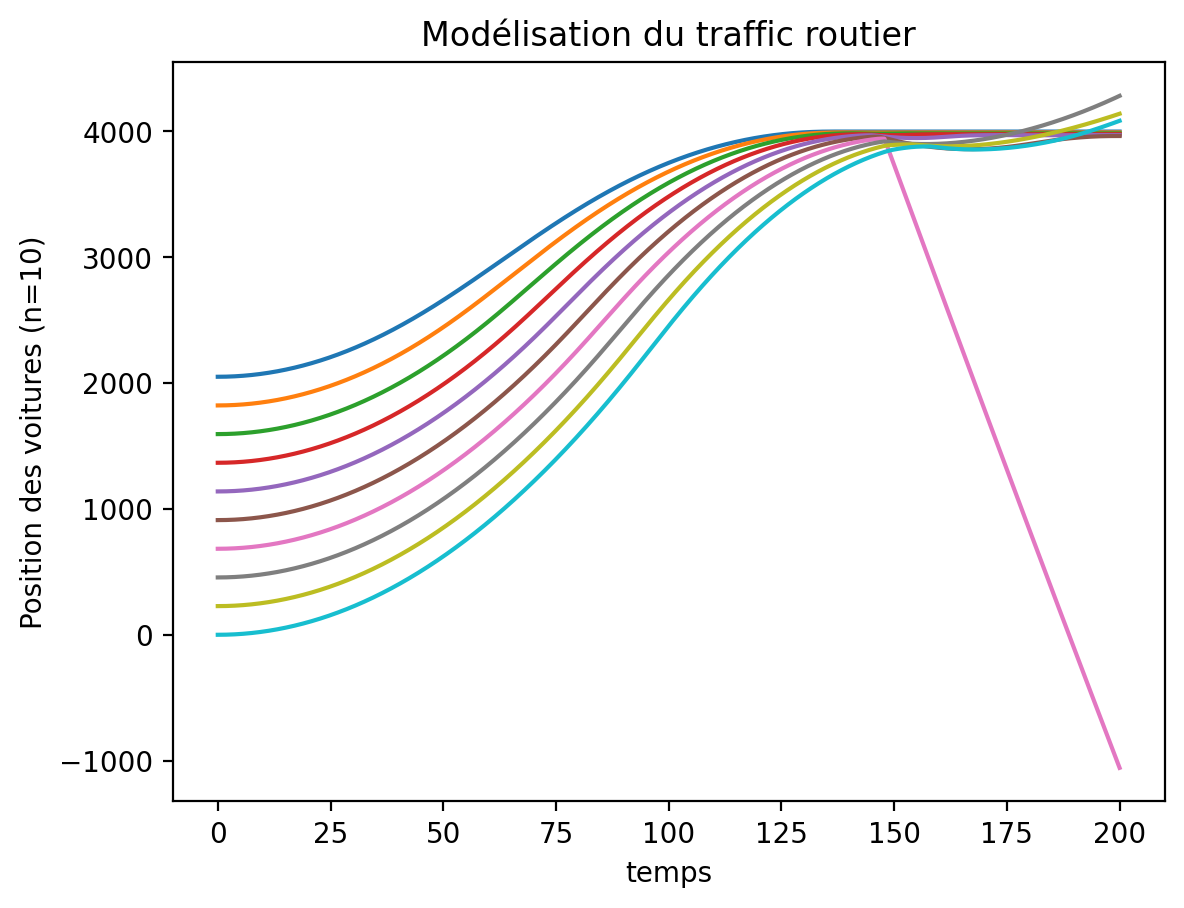

In [261]:
n,v0,s0,T,a,b,l = liste_param[0].values() #On extrait les paramètres
K = 20000 #Le nombre de fois où la boucle du schéma Euler va être affectuée, correspond au temps au pas de temps près. (T=K*dt)
t,X,V,A = trafic_euler_feu_rouge(n, v0, s0, T, a, b, l,K)

# A modifier: M représente la courbe qui sera affichée
M = X # prend les valeurs: X,V,A
ylabel = "Position" if M.all()==X.all() else ("Vitesse" if M.all()==V.all() else "Acceleration")  

for v in range(n):
    x = M[:,v]
    plt.plot(t,x)
    
plt.xlabel("temps")
plt.ylabel(f"{ylabel} des voitures (n={n})")
plt.title("Modélisation du traffic routier");

###### Exemple de comportement artificiel: 
Nous allons illustrer les propos ci dessus en fournissant un exemple de comportement artificiel.

###### *Idée:* 
Puisque l'accéleration décroit quand une voiture est proche de sa vitesse maximale, la voiture qui est derrière a toujours une accéleration élevée (et donc une vitesse plus grande). Lorsque la voiture de derrière se rapproche trop de la voiture de devant elle sur-compense et décelère trop.
Ce phénomène peut arriver à plusieurs voitures les unes après les autres, et donc se propager et s'amplifier. 
Lorsque la première voiture suit une vitesse sinusoîdale on peut induire une cascade de décélérations qui s'amplifie de voiture en voiture:

In [262]:
def vitesse_premiere_voiture(t):
    '''
    On commence par donner une vitesse sinusoidale à la voiture
    '''
    return np.sin(t)

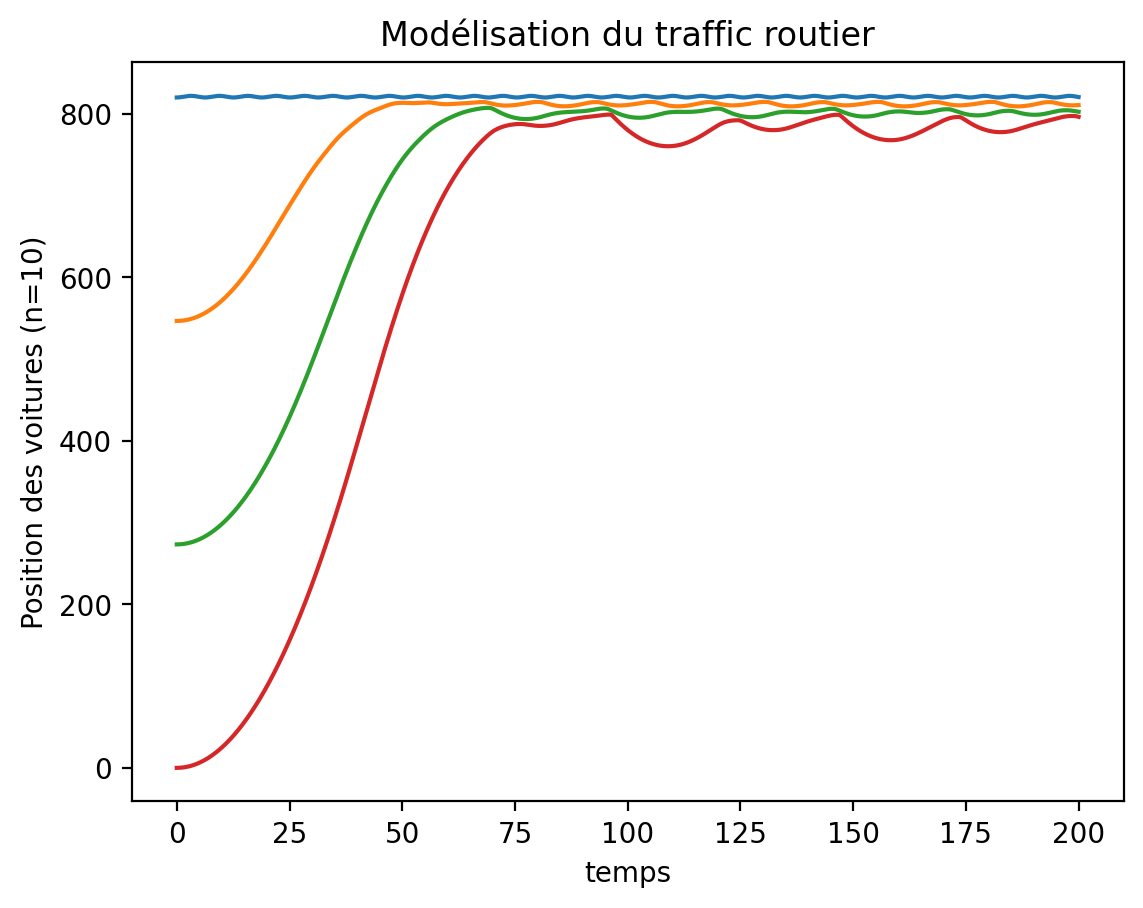

In [263]:
n,v0,s0,T,a,b,l = liste_param[0].values() #On extrait les paramètres
K = 20000 #Le nombre de fois où la boucle du schéma Euler va être affectuée, correspond au temps au pas de temps près. (T=K*dt)
nb_voit_comp_art = 4 #nombre de voitures pour cet exmple
t,X,V,A = trafic_euler_vitesse_predef(nb_voit_comp_art, v0, s0, T, a, b, l,K)

# A modifier: M représente la courbe qui sera affichée
M = X # prend les valeurs: X,V,A
ylabel = "Position" if M.all()==X.all() else ("Vitesse" if M.all()==V.all() else "Acceleration")  

for v in range(nb_voit_comp_art):
    x = M[:,v]
    plt.plot(t,x)
    
plt.xlabel("temps")
plt.ylabel(f"{ylabel} des voitures (n={n})")
plt.title("Modélisation du traffic routier");

###### commentaire: On peut se poser la question si cet exemple est bien une critique de notre modèle mathématique. En effet aucune voiture dans la vie réelle ne suit une vitesse sinusoîdale, donc même si le comportement des voitures qui viennent derrière est artificiel et peu réaliste cette situation n'arriverait jamais dans le monde présent.  

<a id='partie1pastemps'></a>
## Valeur optimale pour le pas de temps $dt$

## Problème:
Pour l'instant nous avons choisi un pas de temps très petit ($dt$<0.01) pour éviter tout problème dans le modèle.
Si le pas de temps est trop grand et que la vitesse est trop élevée aussi, il se pourrait qu'une voiture en dépasse une autre (ce qui est problématique d'un point de vue physique quand il n'y a qu'une seule voie).

Nous allons donc tenter de trouver une solution mathématique à ce problème, c'est à dire trouver un pas de temps minimal pour que tout se passe bien, et puis simuler.


### Partie Maths:

On se ramène à un problème sur deux voitures $V0$ et $V1$.
Soit $x0$, $x1$ (avec $x0$ $>$ $x1$) leur positions et $v0$, $v1$ leur vitesses respectives. 
Soit $l$ la longueur d'une voiture.

Pour que la voiture $V1$ ne dépasse pas la voiture $V0$ on souhaite que, à un temps donné la différence de vitesse des deux voitures ne soit pas plus grande que la distance entre les deux voitures.

- Soit la distance entre les deux voitures:  $D= x0-x1-l$
- Soit la différence de vitesse entre les voitures: $A = dt*(v1-v0)$

On veut que: $A < D$.


Donc on souhaite que: $dt < \large\frac{(x0-x1-l)}{(v1-v0)}$

##### Testons en simulant deux voitures !

### Partie simulation numérique:

On va simuler le comportement de deux voitures qui ont une vitesse constante. L'objectif sera de tester notre hypothèse mathématique, et de fournir des paramètres adéquois à la fonction euler afin d'obtenir un comportement abberant, càd une collision.
On commence par définir les paramètres:

In [264]:
'''
Un exemple de fonction euler avec un dt très élevé
'''
def trafic_euler_feu_rouge_demo(n, v0, s0, T, a, b, l,K):
    X = np.zeros((K,n))
    X[0] = np.linspace(n*(l+100*s0),0, n)
    V = np.zeros((K,n))
    A = np.zeros((K,n))
    t = np.zeros(K)
    dt = 3
    
    for k in range(1,K):
        t[k] = t[k-1]+dt
        for v in range(n):
            if v ==0:
                dv = abs(V[k-1][v])
                ds = dfs(V[k-1][v],dv,s0,a,b,T)
                sn = 4000-X[k-1][v] #distance au feu rouge
            else:
                dv = abs(V[k-1][v-1]-V[k-1][v])
                sn = X[k-1][v-1]-X[k-1][v] - l 
                ds = dfs(V[k-1][v],dv,s0,a,b,T)
            A[k][v] = acceleration(a,V[k-1][v],v0,ds,sn)
            V[k][v] = V[k-1][v]+A[k-1][v]*dt
            X[k][v] = X[k-1][v]+V[k-1][v]*dt
    return t,X,V,A

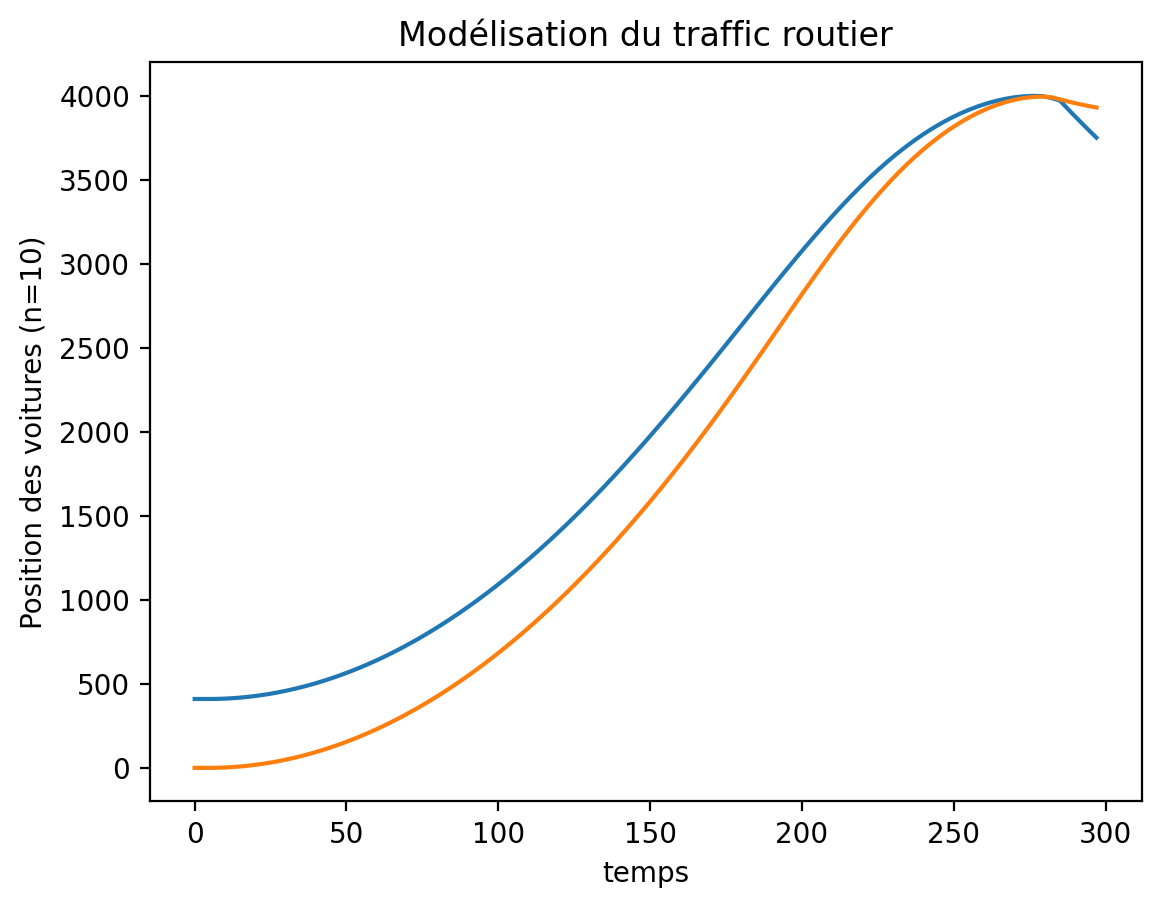

In [268]:
K = 100 #Le nombre de fois où la boucle du schéma Euler va être affectuée, correspond au temps au pas de temps près. (T=K*dt)
#t,X,V = trafic_euler_demo_dt(x0, x1, v0, v1, l, dt,K)
t,X,V,A = trafic_euler_feu_rouge_demo(2, v0, s0, T, 0.15, b, l,K)
# A modifier: M représente la courbe qui sera affichée
M = X # prend les valeurs: X,V,A
ylabel = "Position" if M.all()==X.all() else ("Vitesse" if M.all()==V.all() else "Acceleration")  

for v in range(2):
    x = M[:,v]
    plt.plot(t,x)
    
plt.xlabel("temps")
plt.ylabel(f"{ylabel} des voitures (n={n})")
plt.title("Modélisation du traffic routier");

<a id='partie1tempsreac'></a> 
## Ajout d'un temps de réaction

Les conducteurs dans la vraie vie n'adaptent pas immédiatement leur comportement face à un évênement, le cerveau prend un certain temps à percevoir l'information, à prendre une décision, puis à renvoyer une impulsion électrique aux muscles pour l'implémenter.

Nous souhaitons modéliser ce phénomène et déterminer ses conséquences sur le comportement des voitures.

Encore une fois nous partageront le travail entre une partie maths et une partie modélisation numérique.

#### Partie maths:

La seule chose qui va changer est le moment où la voiture $n$ sera au courant de de la position et de la vitesse de la voiture $n-1$. On va ajouter $\tau$ qui représente le temps de réaction d'une personne dans le calcul de l'accélération.

- $x'_n(t) = v_n(t)$
- $ds(v, dv) = s_0 + max( 0, T*v + \frac{v * dv}{2 * \sqrt{ab}})$ 
- $a_n(t+\tau)=v'_n(t) = a(1 - (v_n(t) / v_0)^4 - (ds(v_n, dv_n)/s_n)^2)$ 
- $x_n(0) = n(1+100*s0)$


#### Partie modélisation:

Nous devons un peu modifier la fonction euler afin de prendre en compte les nouveaux changements:

In [266]:
"""
renvoie les vecteurs position, vitesse et acceleration pour chaque voiture (n voitures),
et pour un certain nombre de répetitions (K), le temps total écoulé sera de t=K*dt
On ajoute un temps de réaction tr
"""
def trafic_euler_tr(n, v0, s0, T, a, b, l,K,tr,dt):
    X = np.zeros((K,n))
    X[[x for x in range(0,tr)]] = np.linspace(n*(l+10*s0),0, n)
    V = np.zeros((K,n))
    A = np.zeros((K,n))
    t = np.zeros(K)
    
    for k in range(tr,K):
        t[k] = t[k-1]+dt
        for v in range(n):
            if v ==0:
                ds = 0
                sn = 1
            else:
                dv = abs(V[k-tr][v-1]-V[k-tr][v])
                sn = X[k-tr][v-1]-X[k-tr][v] - l 
                ds = dfs(V[k-tr][v],dv,s0,a,b,T)
            A[k][v] = acceleration(a,V[k-1][v],v0,ds,sn)
            V[k][v] = V[k-1][v]+A[k-1][v]*dt
            X[k][v] = X[k-1][v]+V[k-1][v]*dt
    return t,X,V,A

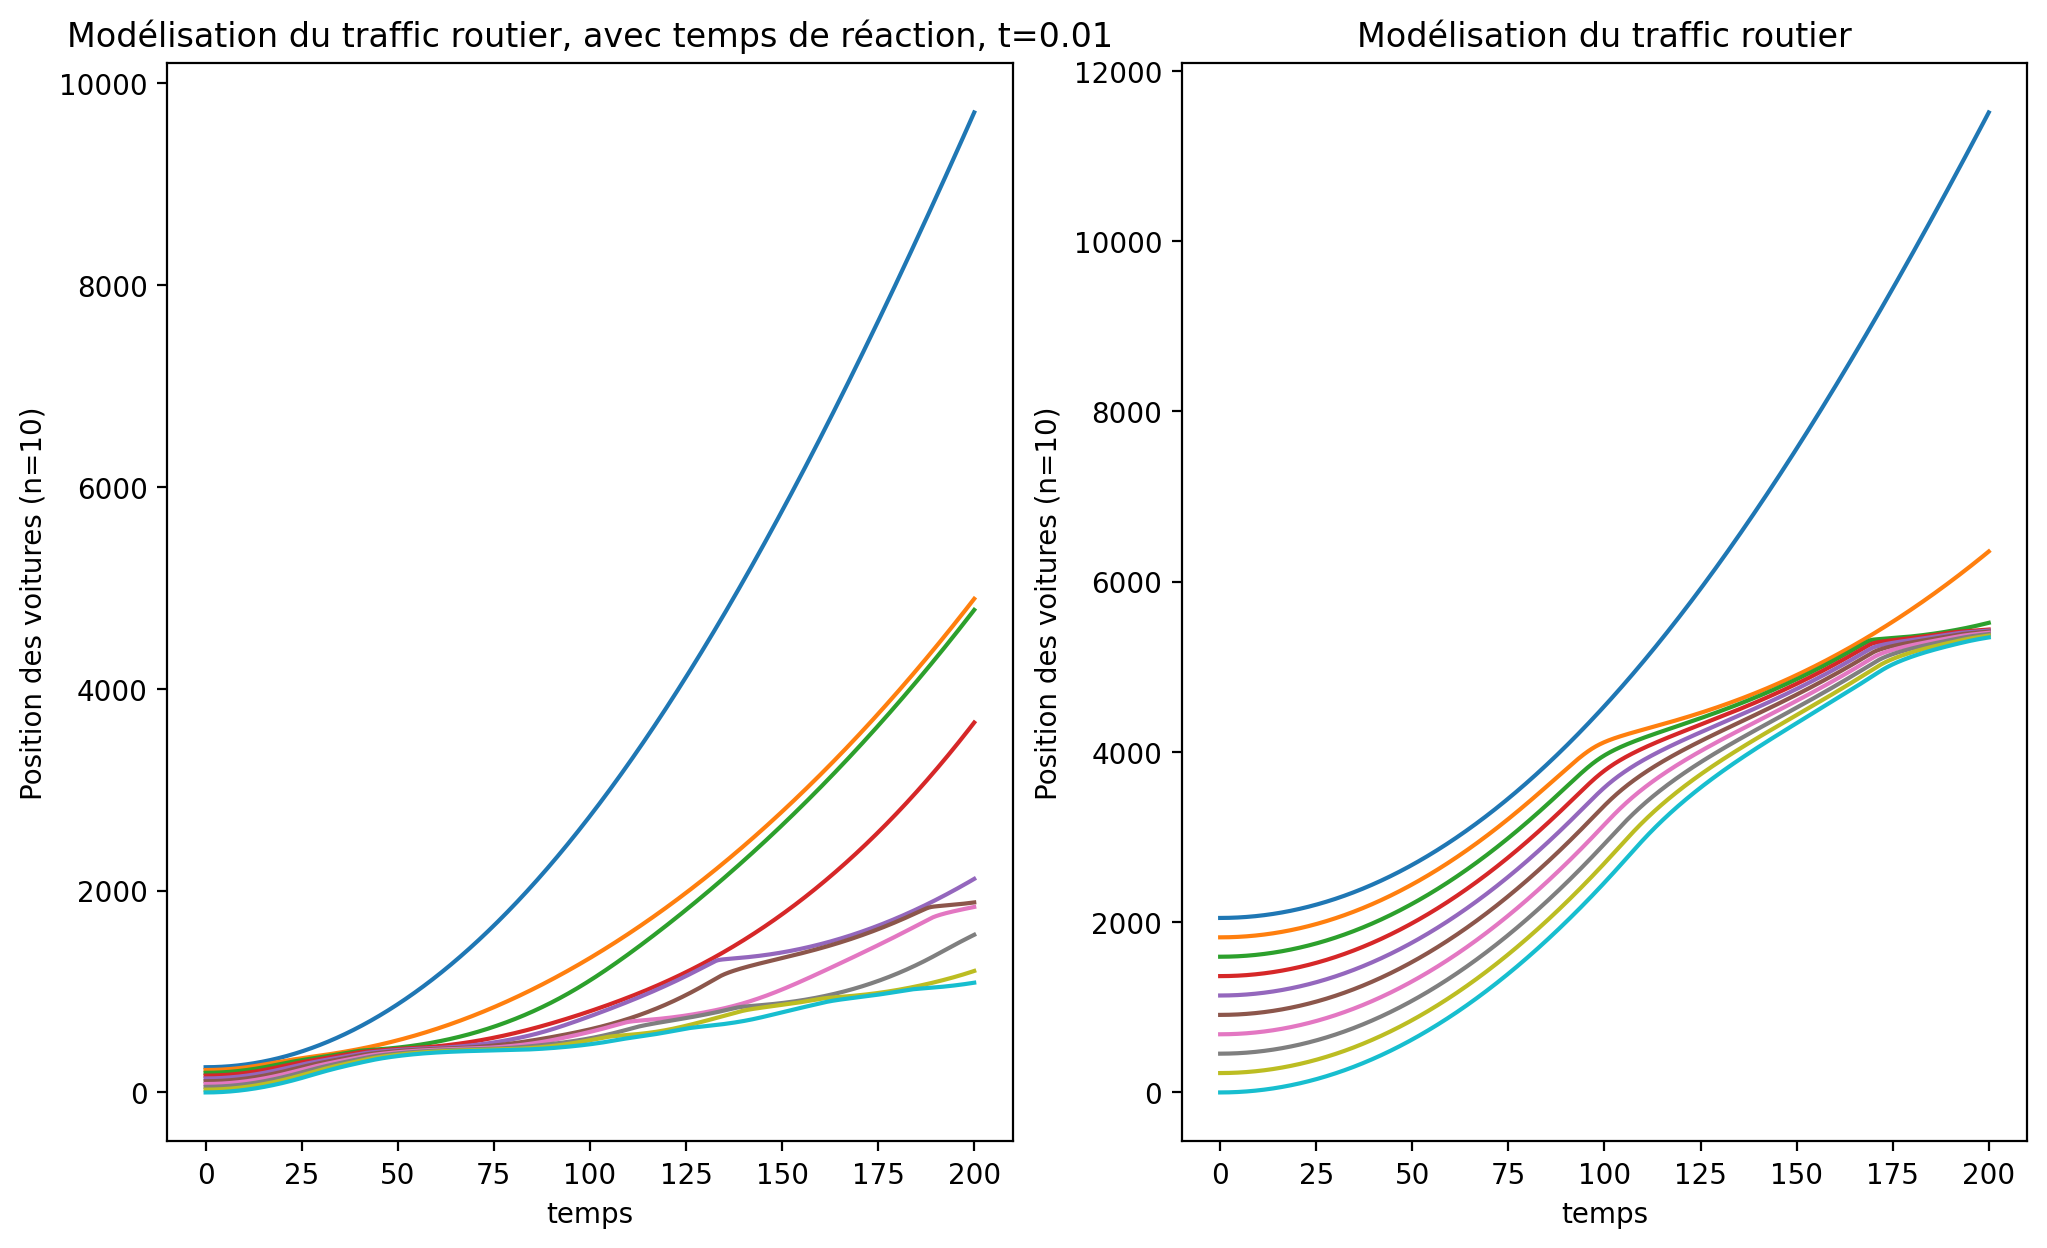

In [267]:
n,v0,s0,T,a,b,l = liste_param[0].values()
K = 20000

tr = 1
dt = 0.01

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,7))

t,X,V,A = trafic_euler_tr(n, v0, s0, T, a, b, l,K,tr,dt)
M = X # prend les valeurs: X,V,A
ylabel = "Position" if M.all()==X.all() else ("Vitesse" if M.all()==V.all() else "Acceleration")  
for v in range(n):
    x = M[:,v]
    ax1.plot(t,x)
    ax1.set_xlabel("temps")
    ax1.set_ylabel(f"{ylabel} des voitures (n={n})")
    ax1.set_title(f"Modélisation du traffic routier, avec temps de réaction, t={tr*dt}");


t,X,V,A = trafic_euler(n, v0, s0, T, a, b, l,K)
# A modifier: M représente la courbe qui sera affichée
M = X # prend les valeurs: X,V,A
ylabel = "Position" if M.all()==X.all() else ("Vitesse" if M.all()==V.all() else "Acceleration")  
for v in range(n):
    x = M[:,v]
    ax2.plot(t,x)
    
    ax2.set_xlabel("temps")
    ax2.set_ylabel(f"{ylabel} des voitures (n={n})")
    ax2.set_title("Modélisation du traffic routier");

###### commentaire: on observe un "lag" chez les voitures qui mettent plus de temps à suivre les les voitures de devant, ce qui créé un effet de lissage. L'écoulement des voitures est moins efficace.

<a id='partie2'></a>
##  Conclusion 

La partie microscopique s'intéressait au comportement de chaque voiture individuellement. 

### Critique du modèle microscopique:   
Nous nous sommes apperçus que le comportement des voitures individuelles ne suit pas toujours le modèle mathématique: 
- Le modèle microscopique ne décrit pas le comportement de personnes réelles
- Il y a des différences entre individus et voitures que le modèle ne prend pas en compte (nous pourrions donner des paramètres aléatoires à chaque voiture afin de modéliser un écoulement plus réaliste. Nous savons qu'une grande quantité de caractéristiques humaines sont distribuées sur une gaussienne (https://fr.wikipedia.org/wiki/Loi_normale) Les paramètres pourraient par exemple aussi être distribués de cette manière)
- Le modèle ne prend pas en compte les différences d'environnement, ex: si il y a de la pluie, si il fait sombre, etc ... 
- Il est facile d'induire des bugs dans le modèle



### Un autre modèle: approche macroscopique
Finalement serait aussi intéressant de "dézoomer" et de regarder le comportement global du système, et à en tirer des informations comme la vitesse moyenne, la densité de voitures.

De plus si nous sommes le gouvernement nous ne sommes pas intéressés par le comportement de chaque voiture, nous souhaitons connaître la probabilité d'un accident, l'écoulement des voitures au niveau des feux et des ronds points, afin de diminuer le nombre d'accidents ou optimiser le temps des feux par exemple pour minimiser le temps que chaque voiture passe à l'arrêt.